This notebook organizes all the results in the "analysis" folder within a concrete storyline

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import ranksums
import seaborn as sns
import statsmodels.api as sm
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 8, 6
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

d:\applications\anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Preparing the data
We wish to have a table that looks like:

In [3]:
t = [['student','variable','pre','post','index','sim','CVS table','CVS graph']]
t.append(['s1','v1','1.0','2.333','1','L','Yes','No'])
t.append(['s1','v2','...','...','1','L','Yes','Yes'])
t.append(['s1','v3','...','...','2','C','No','No'])
t.append(['s1','v4','...','...','2','C','Yes','No'])
print tabulate(t)

-------  --------  ---  -----  -----  ---  ---------  ---------
student  variable  pre  post   index  sim  CVS table  CVS graph
s1       v1        1.0  2.333  1      L    Yes        No
s1       v2        ...  ...    1      L    Yes        Yes
s1       v3        ...  ...    2      C    No         No
s1       v4        ...  ...    2      C    Yes        No
-------  --------  ---  -----  -----  ---  ---------  ---------


## Grabing the CVS data...

In [4]:
table_cvs_df = pd.read_csv('table_cvs_results.txt', sep='\t')
graph_cvs_df = pd.read_csv('graph_cvs_results.txt', sep='\t')

In [5]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
graph_cvs_df['activity order'] = graph_cvs_df.studentid.apply(lambda sid: order[sid])
table_cvs_df['activity order'] = table_cvs_df.studentid.apply(lambda sid: order[sid])

In [6]:
variables = ["Area","Separation","Width","Concentration","Wavelength","Battery voltage"]

def binarize(number):
    if number>0 : return 1
    else: return 0

graph_cvs_df2 = graph_cvs_df.copy()
for v in variables:
    graph_cvs_df2[v] = graph_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

table_cvs_df2 = table_cvs_df.copy()
for v in variables:
    table_cvs_df2[v] = table_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

graph_cvs_df2['sum'] = graph_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum'] = table_cvs_df2[variables].sum(axis=1)

table_cvs_df2['sum caps'] = table_cvs_df2[['Area','Separation']].sum(axis=1)
table_cvs_df2['sum light'] = table_cvs_df2[["Width","Concentration"]].sum(axis=1)

graph_cvs_df2['sum caps'] = graph_cvs_df2[['Area','Separation']].sum(axis=1)
graph_cvs_df2['sum light'] = graph_cvs_df2[["Width","Concentration"]].sum(axis=1)
table_cvs_df2.head()

,studentid,Battery voltage,Area,Separation,Wavelength,Width,Concentration,activity order,sum,sum caps,sum light
0,11612162,0,0,0,1,1,1,CL,3,0,2
1,13660166,0,0,0,0,0,1,LC,1,0,1
2,41947147,1,0,0,1,1,1,CL,4,0,2
3,64006159,0,0,0,1,0,1,LC,2,0,1
4,15749160,0,1,1,0,1,1,CL,4,2,2


In [7]:
table_intervals_df = pd.read_csv('table_intervals_results.txt', sep='\t')

## Grabbing the worksheet data

In [8]:
%reload_ext utils_read_parsing
#grab worksheet data
worksheets = get_worksheet_metadata('beers')
pre = get_pre_worksheet(sim='beers')
main = get_main_worksheet(sim='beers')

ids = get_students_to_analyze_log_worksheets('beers')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre['sid'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])
main['sid'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

# print len(ids),len(pre),len(main)

In [9]:
## make desired table for beers
melted_pre = pd.melt(pre, id_vars=['sid'], value_vars=['Concentration','Width'], var_name='variable',value_name='pre')
melted_main = pd.melt(main, id_vars=['sid'], value_vars=['Concentration','Width'], var_name='variable',value_name='main')

L_scores = melted_pre.merge(melted_main, on=['sid','variable'], how='outer')
L_scores['sim'] = 'L'

L_scores['CVS_table'] = L_scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['CVS_graph'] = L_scores.apply(lambda row: graph_cvs_df2.loc[graph_cvs_df2[graph_cvs_df2['studentid']==row['sid']].index[0],row['variable']],axis=1)

L_scores['sim_index'] = L_scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['sid']].index[0],'activity order'].index(row['sim'])+1,axis=1)

In [10]:
# L_scores.sort_values('sid').head()

In [11]:
%reload_ext utils_read_parsing
#grab worksheet data
worksheets = get_worksheet_metadata('caps')
pre = get_pre_worksheet(sim='caps')
main = get_main_worksheet(sim='caps')

ids = get_students_to_analyze_log_worksheets('caps')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre['sid'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])
main['sid'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

# print len(ids),len(pre),len(main)

In [12]:
## make desired table for caps
melted_pre = pd.melt(pre, id_vars=['sid'], value_vars=['Area','Separation'], var_name='variable',value_name='pre')
melted_main = pd.melt(main, id_vars=['sid'], value_vars=['Area','Separation'], var_name='variable',value_name='main')

C_scores = melted_pre.merge(melted_main, on=['sid','variable'], how='outer')
C_scores['sim'] = 'C'

C_scores['CVS_table'] = C_scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['CVS_graph'] = C_scores.apply(lambda row: graph_cvs_df2.loc[graph_cvs_df2[graph_cvs_df2['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['sim_index'] = C_scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['sid']].index[0],'activity order'].index(row['sim'])+1,axis=1)

In [13]:
data = pd.concat([L_scores,C_scores])
# data['intervals_in_table'] = data.apply(lambda row: table_intervals_df.loc[table_intervals_df[table_intervals_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
# data['CVS_table_only'] = data.apply(lambda row: row['CVS_table']*(1-row['CVS_graph']), axis = 1)
data = data.reset_index(drop=True)
data.sort_values('sid').head(12)

,sid,variable,pre,main,sim,CVS_table,CVS_graph,sim_index
0,10127163,Concentration,1.0,3.0,L,1,1,1
148,10127163,Width,1.0,3.0,L,1,1,1
296,10127163,Area,3.0,3.0,C,1,1,2
444,10127163,Separation,3.0,3.0,C,1,1,2
538,10192168,Separation,1.0,2.0,C,1,1,1
96,10192168,Concentration,1.0,3.0,L,1,1,2
390,10192168,Area,1.0,2.0,C,1,0,1
244,10192168,Width,1.0,0.0,L,1,0,2
1,10232160,Concentration,1.0,1.0,L,1,1,1
149,10232160,Width,1.0,1.0,L,0,0,1


## Stats tools and multicollinearity check

In [14]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def clean_summary(model):
    lines = model.summary().as_text().split('\n')
    lines = [l for l in lines if 'C(sid)' not in l]
    return '\n'.join(lines)

In [15]:
from scipy import stats
print "Correlation coeff for table and graph CVS:", stats.spearmanr(data['CVS_table'],data['CVS_graph'])

Correlation coeff for table and graph CVS: SpearmanrResult(correlation=0.61892063046789791, pvalue=6.9922209879042454e-64)


Let's measure the variance inflation factor of including both CVS table and graph in the same models:

In [16]:
formula = 'CVS_table ~ CVS_graph + pre + C(variable) + C(sim_index) + C(sim) '
print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, data, return_type = 'dataframe')
# print X.columns
logit = Logit(Y, X)
model = logit.fit()
print model.summary()
# print model.params

model:  CVS_table ~ CVS_graph + pre + C(variable) + C(sim_index) + C(sim)  

         Current function value: 0.344469
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              CVS_table   No. Observations:                  592
Model:                          Logit   Df Residuals:                      585
Method:                           MLE   Df Model:                            6
Date:                Tue, 23 Jan 2018   Pseudo R-squ.:                  0.4225
Time:                        13:36:57   Log-Likelihood:                -203.93
converged:                      False   LL-Null:                       -353.12
                                        LLR p-value:                 1.806e-61
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      

d:\applications\anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [17]:
R2 = 0.4225
VIF = 1.0/(1-R2)
VIF

1.7316017316017316

A VIF of 1.73 tells us that the variance (the square of the standard error) of a particular coefficient is 73% larger than it would be if that predictor was completely uncorrelated with all the other predictors. According to [this website](https://statisticalhorizons.com/multicollinearity), a VIF of 2.6 or higher is worrisome.

# Results to present in methods
## Student population

In [18]:
N = len(set(data['sid']))
print "The study includes {0} students".format(N)

The study includes 148 students


In [19]:
print 'Gender distribution'

Gender distribution


## Student prior experience

In [20]:
print 'Undergraduate year level'

Undergraduate year level


In [21]:
print "# intended majors or %intended majors by faculty or outside chem/phys"

# intended majors or %intended majors by faculty or outside chem/phys


In [22]:
print 'Lab courses taken in pphysics and chemistry'

Lab courses taken in pphysics and chemistry


In [23]:
print 'experience in virtual labs in general'

experience in virtual labs in general


In [24]:
print  'experience in virutal labs teaching light absorbance or capacitors before'

experience in virutal labs teaching light absorbance or capacitors before


# Learning through inquiry
## Overall

Let's look at pre to post to see if students learn.

Right now we have 4 entries per student and add "variable" to the model. But then pre matters (p=0.04)
But we could have main = mean(var1 and var 2 scores). In which case pre doesn't matter (p=0.056)
Either way with tiny effect size.

In [25]:
scores = pd.pivot_table(data, values=['pre','main'], index=['sim','sid'],aggfunc=np.mean)
scores.reset_index(level=0, inplace=True)
scores['sid']=scores.index
scores.index = scores['sim']
scores.head()

,sim,main,pre,sid
sim,,,,
C,C,3.0,3.0,10127163
C,C,2.0,1.0,10192168
C,C,3.0,1.0,10232160
C,C,3.0,1.0,10375163
C,C,2.5,2.0,10420167


In [26]:
scores.loc['C'].shape

(148, 4)

In [30]:
t = [['sim','pre','post','Z','p','effect size']]
for sim in ['L','C']:
    pm = round(np.mean(scores.loc[sim]['pre']),2)
    ps = round(np.std(scores.loc[sim]['pre']),2)
    mm = round(np.mean(scores.loc[sim]['main']),2)
    ms = round(np.std(scores.loc[sim]['main']),2)
    Z,p = ranksums(scores.loc[sim]['pre'],scores.loc[sim]['main'])
    eta = round(-Z/np.sqrt(N),2)
    t.append([sim,str(pm)+'+/-'+str(ps),str(mm)+'+/-'+str(ms),Z,p,eta])

print tabulate(t)

---  -----------  -----------  --------------  -----------------  -----------
sim  pre          post         Z               p                  effect size
L    1.17+/-0.69  2.35+/-0.63  -11.2795122375  1.65661938815e-29  0.93
C    1.28+/-0.67  2.24+/-0.63  -10.5732694484  3.9642841333e-26   0.87
---  -----------  -----------  --------------  -----------------  -----------


We use Wilcoxon signed rank test since our population ares paired and dependant but ordinal values. Overall, student learn in both sims.

For calculation and interpretation of effect size, read Pages 224 (bottom part) and 225 from Pallant, J. (2007). SPSS Survival Manual quoted [here](https://stats.stackexchange.com/questions/133077/effect-size-to-wilcoxon-signed-rank-test)


# Does using strategy help student learn?

## Using different levels of CVS and learning
We add a "CVS_levels" column to our data (graph=2, table=1, none=0)

In [31]:
data['CVS_levels']=0
data['CVS_table_only'] = data.apply(lambda row: row['CVS_table']*(1-row['CVS_graph']), axis = 1)
data['CVS_levels']=data['CVS_table']+data['CVS_graph']
# print data[(data['CVS_table']==0)&(data['CVS_graph']==1)].shape
data.head()

,sid,variable,pre,main,sim,CVS_table,CVS_graph,sim_index,CVS_levels,CVS_table_only
0,10127163,Concentration,1.0,3.0,L,1,1,1,2,0
1,10232160,Concentration,1.0,1.0,L,1,1,1,2,0
2,10537160,Concentration,1.0,2.0,L,1,0,2,1,1
3,10375163,Concentration,0.0,2.0,L,1,0,2,1,1
4,10420167,Concentration,1.0,3.0,L,1,1,2,2,0


We have 4 control variables:
* sim_index
* sim
* variable
* pre

We look at all interactions with CVS levels given our RQ are related to CVS usage:
* variable*CVS_levels
* pre*CVS_levels
* sim_index*CVS_levels
* sim
* C(sid)

In [32]:
formula = 'main ~ C(CVS_levels)*variable + C(CVS_levels)*pre + C(CVS_levels)*C(sim_index) + C(sid) + C(sim)'
model = ols(formula, data).fit()
print "Model: ",formula
aov_table = anova_lm(model, typ=1)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 1\n"
print(aov_table)
print "\nHere is the linear model with coefficients and confidence intervals (removed stats for individual student ids):\n"
print clean_summary(model)

Model:  main ~ C(CVS_levels)*variable + C(CVS_levels)*pre + C(CVS_levels)*C(sim_index) + C(sid) + C(sim)

Anova table using type 1

                               df   sum_sq  mean_sq       F     PR(>F)  eta_sq   omega_sq
C(CVS_levels)                 2.0   29.992   14.996  53.929  1.311e-21   0.103  1.005e-01
variable                      3.0    2.549    0.850   3.055  2.826e-02   0.009  5.856e-03
C(sim_index)                  1.0    3.401    3.401  12.231  5.193e-04   0.012  1.067e-02
C(sid)                      147.0  133.204    0.906   3.259  2.441e-21   0.455  3.154e-01
C(sim)                        1.0    1.051    1.051   3.781  5.250e-02   0.004  2.641e-03
C(CVS_levels):variable        6.0    1.528    0.255   0.916  4.832e-01   0.005 -4.798e-04
C(CVS_levels):C(sim_index)    2.0    0.527    0.264   0.948  3.882e-01   0.002 -9.794e-05
pre                           1.0    0.739    0.739   2.657  1.038e-01   0.003  1.574e-03
C(CVS_levels):pre             2.0    0.756    0.378   1.35

d:\applications\anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
d:\applications\anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
d:\applications\anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            OLS Regression Results                            
Dep. Variable:                   main   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     3.783
Date:                Tue, 23 Jan 2018   Prob (F-statistic):           2.84e-28
Time:                        13:49:09   Log-Likelihood:                -364.46
No. Observations:                 592   AIC:                             1059.
Df Residuals:                     427   BIC:                             1782.
Df Model:                         164                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

## Parsimonious model
Since none of the interactions matter, we remove them and opt for a parsimonious model.

In [33]:
formula = 'main ~ C(CVS_levels) + variable + pre + C(sim_index) + C(sid) + C(sim)'
model = ols(formula, data).fit()
print "Model: ",formula
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 2\n"
print(aov_table)
print "\nHere is the linear model with coefficients and confidence intervals (removed stats for individual student ids):\n"
print clean_summary(model)

Model:  main ~ C(CVS_levels) + variable + pre + C(sim_index) + C(sid) + C(sim)

Anova table using type 2

                sum_sq     df       F     PR(>F)  eta_sq   omega_sq
C(CVS_levels)    4.514    2.0   8.131  3.411e-04   0.017  1.532e-02
variable         3.033    3.0   3.643  1.283e-02   0.012  8.517e-03
C(sim_index)     3.862    1.0  13.911  2.169e-04   0.015  1.387e-02
C(sid)         124.041  147.0   3.040  3.415e-19   0.481  3.221e-01
C(sim)           0.527    1.0   1.898  1.690e-01   0.002  9.652e-04
pre              0.819    1.0   2.951  8.656e-02   0.003  2.096e-03
Residual       121.304  437.0     NaN        NaN     NaN        NaN

Here is the linear model with coefficients and confidence intervals (removed stats for individual student ids):

                            OLS Regression Results                            
Dep. Variable:                   main   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.437

## Post-hoc analysis on levels

In [34]:
'main ~ C(CVS_levels) + variable + pre + C(sim_index) + C(sid) + C(sim)'
print "Comparing CVS levels 0 and 1"
model = ols(formula, data[data['CVS_levels']!=2]).fit()
print "Model: ",formula
print 'where levels = (0,1)'
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 2 errors\n"
print(aov_table)

Comparing CVS levels 0 and 1
Model:  main ~ C(CVS_levels) + variable + pre + C(sim_index) + C(sid) + C(sim)
where levels = (0,1)

Anova table using type 2 errors

               sum_sq     df      F     PR(>F)     eta_sq   omega_sq
C(CVS_levels)   0.300    1.0  1.235  2.678e-01  2.197e-03  4.174e-04
variable        0.495    3.0  0.679  5.660e-01  3.623e-03 -1.711e-03
C(sim_index)    1.361    1.0  5.595  1.902e-02  9.953e-03  8.160e-03
C(sid)         88.100  104.0  3.483  4.429e-14  6.443e-01  4.585e-01
C(sim)          0.244    1.0  1.002  3.181e-01  1.783e-03  3.646e-06
pre             0.016    1.0  0.064  8.008e-01  1.136e-04 -1.662e-03
Residual       46.213  190.0    NaN        NaN        NaN        NaN


In [35]:
formula = 'main ~ C(CVS_levels) + variable + pre + C(sim_index) + C(sid) + C(sim)'
print "Comparing CVS levels 1 and 2"
model = ols(formula, data[data['CVS_levels']!=0]).fit()
print "Model: ",formula
print 'where levels = (1,2)'
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 2 errors\n"
print(aov_table)

Comparing CVS levels 1 and 2
Model:  main ~ C(CVS_levels) + variable + pre + C(sim_index) + C(sid) + C(sim)
where levels = (1,2)

Anova table using type 2 errors

               sum_sq     df      F     PR(>F)     eta_sq  omega_sq
C(CVS_levels)   1.688    1.0  5.918  1.562e-02  9.634e-03     0.008
variable        3.013    3.0  3.521  1.554e-02  1.720e-02     0.012
C(sim_index)    2.613    1.0  9.161  2.702e-03  1.492e-02     0.013
C(sid)         87.216  137.0  2.232  8.367e-09  4.979e-01     0.274
C(sim)          0.075    1.0  0.263  6.085e-01  4.281e-04    -0.001
pre             0.721    1.0  2.528  1.130e-01  4.116e-03     0.002
Residual       79.857  280.0    NaN        NaN        NaN       NaN


In [36]:
formula = 'main ~ C(CVS_levels) + variable + pre + C(sim_index) + C(sid) + C(sim)'
print "Comparing CVS levels 0 and 2"
model = ols(formula, data[data['CVS_levels']!=1]).fit()
print "Model: ",formula
print 'where levels = (0,2)'
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 2 errors\n"
print(aov_table)

Comparing CVS levels 0 and 2
Model:  main ~ C(CVS_levels) + variable + pre + C(sim_index) + C(sid) + C(sim)
where levels = (0,2)

Anova table using type 2 errors

                sum_sq     df       F     PR(>F)  eta_sq   omega_sq
C(CVS_levels)    3.330    1.0  13.391  2.964e-04   0.017  1.576e-02
variable         2.123    3.0   2.846  3.779e-02   0.011  7.043e-03
C(sim_index)     1.972    1.0   7.929  5.173e-03   0.010  8.813e-03
C(sid)         108.418  137.0   3.182  1.748e-17   0.555  3.803e-01
C(sim)           0.365    1.0   1.469  2.264e-01   0.002  5.962e-04
pre              0.713    1.0   2.868  9.136e-02   0.004  2.376e-03
Residual        78.329  315.0     NaN        NaN     NaN        NaN


This plot needs to be redone with standard deviation bars and colored by level and stars given the tests above
0-1 => -
1-2 => *
0-2 => ***


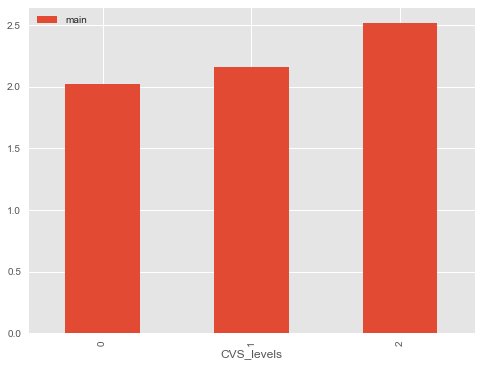

In [37]:
levels = pd.pivot_table(data, values=['main'], index=['CVS_levels'],aggfunc=np.mean)
levels.plot(kind='bar')
print "This plot needs to be redone with standard deviation bars and colored by level and stars given the tests above"
print '0-1 => -'
print '1-2 => *'
print '0-2 => ***'

### Post-hoc analysis on order

This plot needs to be redone with standard deviation bars and organized by sim, colored by level


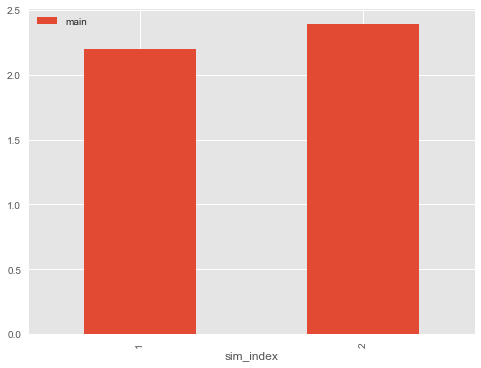

In [38]:
posthoc_sim_index = pd.pivot_table(data, values=['main'], index=['sim_index'],aggfunc=(np.mean))
posthoc_sim_index.plot(kind='bar')
print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

### Post-hoc analysis on variable

This plot needs to be redone with standard deviation bars and organized by sim, colored by level


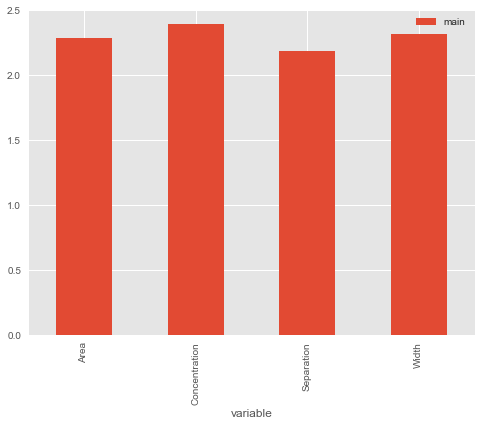

In [39]:
posthoc_variable = pd.pivot_table(data, values=['main'], index=['variable'],aggfunc=(np.mean))
posthoc_variable.plot(kind='bar')
print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

## Let's investigate how CVS relationship with knowledge changes depending on the variable

### Overall - with viz

In [40]:
data.head()

,sid,variable,pre,main,sim,CVS_table,CVS_graph,sim_index,CVS_levels,CVS_table_only
0,10127163,Concentration,1.0,3.0,L,1,1,1,2,0
1,10232160,Concentration,1.0,1.0,L,1,1,1,2,0
2,10537160,Concentration,1.0,2.0,L,1,0,2,1,1
3,10375163,Concentration,0.0,2.0,L,1,0,2,1,1
4,10420167,Concentration,1.0,3.0,L,1,1,2,2,0


In [41]:
per_variable = pd.pivot_table(data, values=['main'], index=['variable','CVS_levels'],aggfunc=(np.mean))
per_variable

main
variable      CVS_levels       
Area          0           1.977
              1           2.188
              2           2.514
Concentration 0           2.128
              1           2.188
              2           2.610
Separation    0           2.065
              1           2.065
              2           2.324
Width         0           1.897
              1           2.184
              2           2.620

This plot needs to be redone with standard deviation bars and organized by sim, colored by level


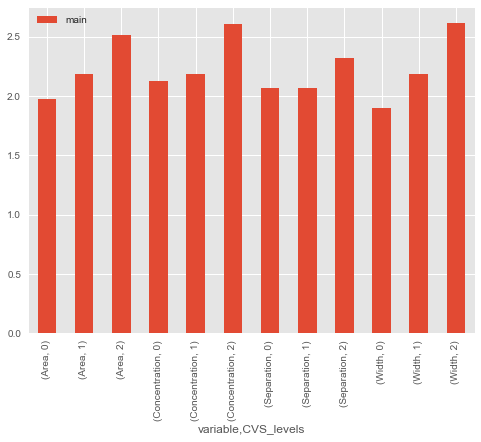

In [42]:
per_variable.plot(kind='bar')
print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

### Width

In [43]:
variable = 'Width'
formula = 'main ~ C(CVS_levels) + pre + C(sim_index) + C(sim)'
model = ols(formula, data[data['variable']==variable]).fit()
print "Model: ",formula
# aov_table = anova_lm(model, typ=2)
# eta_squared(aov_table)
# omega_squared(aov_table)
# print "\nAnova table using type 2 errors\n"
# print(aov_table)
print "\nHere is the linear model with coefficients and confidence intervals:\n"
print clean_summary(model)

Model:  main ~ C(CVS_levels) + pre + C(sim_index) + C(sim)

Here is the linear model with coefficients and confidence intervals:

                            OLS Regression Results                            
Dep. Variable:                   main   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     8.183
Date:                Tue, 23 Jan 2018   Prob (F-statistic):           5.69e-06
Time:                        13:49:16   Log-Likelihood:                -152.90
No. Observations:                 148   AIC:                             315.8
Df Residuals:                     143   BIC:                             330.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      

### Concentration

In [44]:
variable = 'Concentration'
formula = 'main ~ C(CVS_levels) + pre + C(sim_index) + C(sim)'
model = ols(formula, data[data['variable']==variable]).fit()
print "Model: ",formula
# aov_table = anova_lm(model, typ=2)
# eta_squared(aov_table)
# omega_squared(aov_table)
# print "\nAnova table using type 2 errors\n"
# print(aov_table)
print "\nHere is the linear model with coefficients and confidence intervals:\n"
print clean_summary(model)

Model:  main ~ C(CVS_levels) + pre + C(sim_index) + C(sim)

Here is the linear model with coefficients and confidence intervals:

                            OLS Regression Results                            
Dep. Variable:                   main   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     9.025
Date:                Tue, 23 Jan 2018   Prob (F-statistic):           1.58e-06
Time:                        13:49:17   Log-Likelihood:                -128.08
No. Observations:                 148   AIC:                             266.2
Df Residuals:                     143   BIC:                             281.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      

### Area

In [45]:
variable = 'Area'
formula = 'main ~ C(CVS_levels) + pre + C(sim_index) + C(sim)'
model = ols(formula, data[data['variable']==variable]).fit()
print "Model: ",formula
# aov_table = anova_lm(model, typ=2)
# eta_squared(aov_table)
# omega_squared(aov_table)
# print "\nAnova table using type 2 errors\n"
# print(aov_table)
print "\nHere is the linear model with coefficients and confidence intervals:\n"
print clean_summary(model)

Model:  main ~ C(CVS_levels) + pre + C(sim_index) + C(sim)

Here is the linear model with coefficients and confidence intervals:

                            OLS Regression Results                            
Dep. Variable:                   main   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     7.199
Date:                Tue, 23 Jan 2018   Prob (F-statistic):           2.61e-05
Time:                        13:49:18   Log-Likelihood:                -145.21
No. Observations:                 148   AIC:                             300.4
Df Residuals:                     143   BIC:                             315.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      

### Separation

In [46]:
variable = 'Separation'
formula = 'main ~ C(CVS_levels) + pre + C(sim_index) + C(sim)'
model = ols(formula, data[data['variable']==variable]).fit()
print "Model: ",formula
# aov_table = anova_lm(model, typ=2)
# eta_squared(aov_table)
# omega_squared(aov_table)
# print "\nAnova table using type 2 errors\n"
# print(aov_table)
print "\nHere is the linear model with coefficients and confidence intervals:\n"
print clean_summary(model)

Model:  main ~ C(CVS_levels) + pre + C(sim_index) + C(sim)

Here is the linear model with coefficients and confidence intervals:

                            OLS Regression Results                            
Dep. Variable:                   main   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     3.943
Date:                Tue, 23 Jan 2018   Prob (F-statistic):            0.00457
Time:                        13:49:19   Log-Likelihood:                -145.47
No. Observations:                 148   AIC:                             300.9
Df Residuals:                     143   BIC:                             315.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      

Findings:
* CVS_levels=2 (graph) matters for all except Separation
* Pre matters for all except Width

# What affects use CVS-like inquiry strategies?

For some reason adding students in the matric turns it into a singular matrix and fails the analysis. Probably because two students are exactly identical?

## Overall, how much to they use it?

In [47]:
sums = pd.pivot_table(data, values=['CVS_table','CVS_graph'], index=['sid'], aggfunc=np.sum)
sums.head()

,CVS_graph,CVS_table
sid,,
10127163,4,4
10192168,2,4
10232160,3,3
10375163,1,4
10420167,4,4


In [48]:
once = len(sums[sums['CVS_table']>0])/float(N)*100
all4 = len(sums[sums['CVS_table']==4])/float(N)*100
print "{0}% of students use CVS table once and {1}% do it for all variables.".format(int(once),int(all4))
once = len(sums[sums['CVS_graph']>0])/float(N)*100
all4 = len(sums[sums['CVS_graph']==4])/float(N)*100
print "{0}% of students use CVS graph once and {1}% do it for all variables.".format(int(once),int(all4))

93% of students use CVS table once and 47% do it for all variables.
70% of students use CVS graph once and 29% do it for all variables.


## Are they consistent in their usage of CVS graph?

In [49]:
data.head()

,sid,variable,pre,main,sim,CVS_table,CVS_graph,sim_index,CVS_levels,CVS_table_only
0,10127163,Concentration,1.0,3.0,L,1,1,1,2,0
1,10232160,Concentration,1.0,1.0,L,1,1,1,2,0
2,10537160,Concentration,1.0,2.0,L,1,0,2,1,1
3,10375163,Concentration,0.0,2.0,L,1,0,2,1,1
4,10420167,Concentration,1.0,3.0,L,1,1,2,2,0


In [50]:
sums2 = pd.pivot_table(data, values=['CVS_table','CVS_graph'], index=['sid','sim'], aggfunc=np.sum)

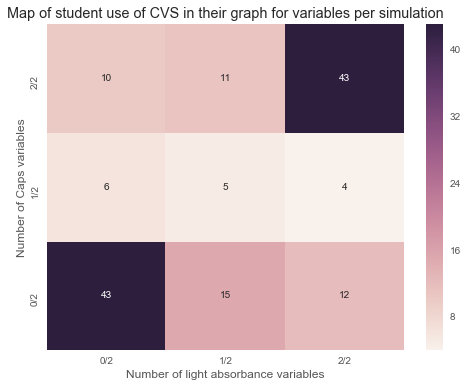

In [51]:
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(graph_cvs_df2[(graph_cvs_df2['sum caps']==i)&(graph_cvs_df2['sum light']==j)])
ax = sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d")
ax.set_xticklabels(['0/2','1/2','2/2'])
ax.set_yticklabels(['0/2','1/2','2/2'])
plt.xlabel('Number of light absorbance variables')
plt.ylabel('Number of Caps variables')
plt.title('Map of student use of CVS in their graph for variables per simulation')

High usage is consistent. If they do CVS with 1 variable in one sim, they do it with 2 in the other (probaly second sim).We'll see how order makes a difference later.

## How does incoming knowledge affect doing CVS

In [52]:
# export_data = data[["sid","variable","pre","main","sim","CVS_graph","sim_index"]]
# export_data.to_csv('dataframe for logreg of CVS.csv')

In [53]:
formula = 'CVS_graph ~ pre*variable + C(sim_index)*variable + pre*C(sim_index) + C(sim)'
print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, data, return_type = 'dataframe')
# print X.columns
logit = Logit(Y, X)
model = logit.fit()
print model.summary()
# print model.paramsdd

model:  CVS_graph ~ pre*variable + C(sim_index)*variable + pre*C(sim_index) + C(sim) 

Optimization terminated successfully.
         Current function value: 0.670840
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              CVS_graph   No. Observations:                  592
Model:                          Logit   Df Residuals:                      579
Method:                           MLE   Df Model:                           12
Date:                Tue, 23 Jan 2018   Pseudo R-squ.:                 0.03198
Time:                        13:49:29   Log-Likelihood:                -397.14
converged:                       True   LL-Null:                       -410.26
                                        LLR p-value:                  0.009915
                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

d:\applications\anaconda2\lib\site-packages\statsmodels\base\model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


### Parismonious model

In [54]:
formula = 'CVS_graph ~ pre + variable + C(sim_index) + C(sim)'
print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, data, return_type = 'dataframe')
# print X.columns
logit = Logit(Y, X)
model = logit.fit()
print model.summary()
# print model.paramsdd

model:  CVS_graph ~ pre + variable + C(sim_index) + C(sim) 

Optimization terminated successfully.
         Current function value: 0.680638
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              CVS_graph   No. Observations:                  592
Model:                          Logit   Df Residuals:                      586
Method:                           MLE   Df Model:                            5
Date:                Tue, 23 Jan 2018   Pseudo R-squ.:                 0.01785
Time:                        13:49:30   Log-Likelihood:                -402.94
converged:                       True   LL-Null:                       -410.26
                                        LLR p-value:                   0.01201
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept        

CVS plotting occurs more in second sim but no interaction with sim type. Pre matters, variable doesn't matter.

### post hoc of pre

Here is the avg pre score of students depending if they do CVS graph or not


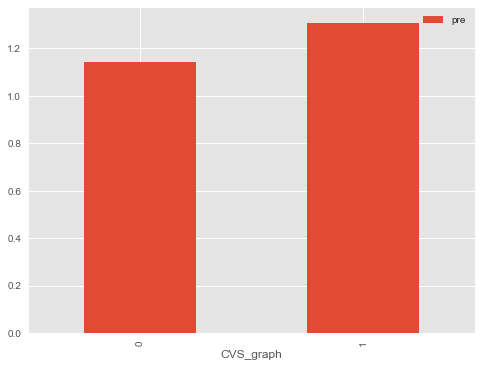

In [61]:
cvs_pre = pd.pivot_table(data, values=['pre'], index=['CVS_graph'],aggfunc=(np.mean))
print "Here is the avg pre score of students depending if they do CVS graph or not"
cvs_pre.plot(kind='bar')

## How do students do CVS differently in the second sim?

Here is the percent of students who do CVS in graph given the order and sim


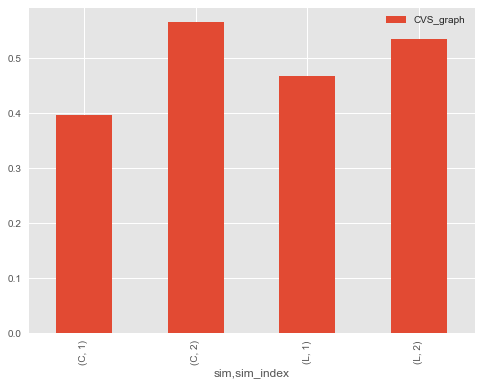

In [56]:
cvs_order_only = pd.pivot_table(data, values=['CVS_graph'], index=['sim','sim_index'],aggfunc=(np.mean))
print "Here is the percent of students who do CVS in graph given the order and sim"
cvs_order_only.plot(kind='bar')

In [57]:
cvs_order = pd.pivot_table(data, values=['CVS_graph'], index=['variable','sim_index'],aggfunc=np.mean)
print "Here is the percent of students who do CVS in the graph for that variable given the order"
cvs_order

Here is the percent of students who do CVS in the graph for that variable given the order


CVS_graph
variable      sim_index           
Area          1              0.389
              2              0.579
Concentration 1              0.500
              2              0.542
Separation    1              0.403
              2              0.553
Width         1              0.434
              2              0.528

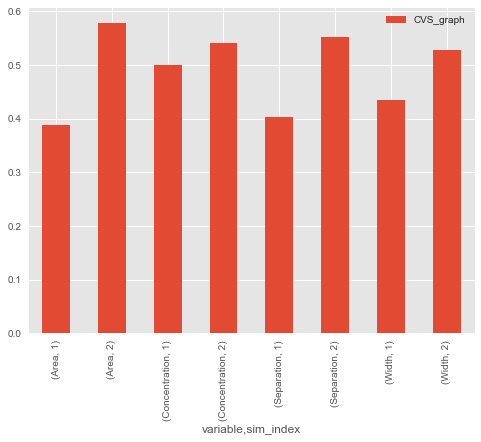

In [58]:
cvs_order.plot(kind='bar')